In [123]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
from sklearn.preprocessing import OneHotEncoder

In [124]:
# 사용하는 데이터 불러오기

condition = ['id', 'host_id', 'price',
             'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'beds', 'amenities']

df = pd.read_csv('2025_Airbnb_NYC.csv', usecols = condition, encoding = 'utf-8' )

In [125]:
# 전처리 1 - id int로 변경
df['id'] = df['id'].astype(int)

In [126]:
# 전처리 1 - price float로 변경
df['price_clean'] = df['price'].str.replace(r'[\$,]', '', regex=True)
df['price_clean'] = df['price_clean'].astype(float)
print(df['price_clean'].head(2))
df['price'] = df['price_clean']
df = df.drop(columns=['price_clean'])

0    200.0
1     82.0
Name: price_clean, dtype: float64


In [127]:
# 전처리 2 - bathrooms / bathrooms_text

# bathrooms의 null값 0으로 채움
df['bathrooms'] = df['bathrooms'].fillna(0)

# bathrooms와 bathrooms_text 숫자 불일치 - half를 full bath로 취급하고 있음
# bathrooms_text의 숫자 값으로 bathrooms 값 업데이트

# 1) bathrooms_text에서 숫자(정수·소수) 또는 "half"를 파싱하는 함수
def parse_baths(text):
    if pd.isna(text):
        return np.nan
    s = str(text).lower()
    m = re.search(r'(\d+(\.\d+)?)', s)
    if m:
        return float(m.group(1))
    if 'half' in s:
        return 0.5
    return np.nan

# 2) 파싱값을 새로운 컬럼에 저장
df['bathrooms_parsed'] = df['bathrooms_text'].apply(parse_baths)

# 3) 불일치 여부 마스크 (parsed와 원본 bathrooms가 다를 때)
mask_mismatch = df['bathrooms_parsed'].notna() & (df['bathrooms'] != df['bathrooms_parsed'])

# 4) bathrooms가 실제 텍스트가 가리키는 값(파싱값)으로 업데이트
df.loc[mask_mismatch, 'bathrooms'] = df.loc[mask_mismatch, 'bathrooms_parsed']

# 5) (선택) helper 컬럼 제거 및 최종 확인
df = df.drop(columns=['bathrooms_parsed'])
#print(df.loc[mask_mismatch, ['bathrooms_text', 'bathrooms']])


In [128]:
# 확인용 - bathroom과 bathrooms_text 일치 여부
# 1) bathrooms_text에서 숫자(또는 “half”)를 추출하는 함수
def parse_baths(text):
    if pd.isna(text):
        return np.nan
    s = str(text).lower()
    # “3.5”, “7” 같은 숫자 먼저 찾기
    m = re.search(r'(\d+(\.\d+)?)', s)
    if m:
        return float(m.group(1))
    # 숫자가 없고 “half”만 있으면 0.5
    if 'half' in s:
        return 0.5
    return np.nan

# 2) 파싱 결과를 새 컬럼에 저장
df['bathrooms_parsed'] = df['bathrooms_text'].apply(parse_baths)

# 3) 원래 bathrooms 값과 일치하는지 불리언 컬럼 생성
df['bathrooms_match'] = df['bathrooms'] == df['bathrooms_parsed']

# 4) 결과 확인하기

# 전체 매칭 비율
match_rate = df['bathrooms_match'].mean()
print(f"일치 비율: {match_rate:.2%}")

# (a) 일치하지 않는 경우들 보기
mismatches = df.loc[~df['bathrooms_match'],
                    ['bathrooms', 'bathrooms_text', 'bathrooms_parsed']]
print("불일치 항목들:")
print(mismatches)

# (b) 파싱 불가능(결과가 NaN)인 경우 보기
unparsed = df.loc[df['bathrooms_parsed'].isna(),
                  ['bathrooms', 'bathrooms_text']]
print("\n파싱 실패(Null) 항목들:")
print(unparsed)

df = df.drop(columns=['bathrooms_parsed', 'bathrooms_match'])



일치 비율: 99.94%
불일치 항목들:
       bathrooms bathrooms_text  bathrooms_parsed
5            0.0            NaN               NaN
232          0.0            NaN               NaN
6512         0.0            NaN               NaN
6963         0.0            NaN               NaN
6970         0.0            NaN               NaN
6989         0.0            NaN               NaN
7009         0.0            NaN               NaN
7030         0.0            NaN               NaN
8629         0.0            NaN               NaN
14591        0.0            NaN               NaN
15585        0.0            NaN               NaN
17862        0.0            NaN               NaN
18434        0.0            NaN               NaN
20366        0.0            NaN               NaN

파싱 실패(Null) 항목들:
       bathrooms bathrooms_text
5            0.0            NaN
232          0.0            NaN
6512         0.0            NaN
6963         0.0            NaN
6970         0.0            NaN
6989         0.0 

In [129]:
# 전처리3_ bathrooms sharing 여부에 따라 화장실 개수에 가중치 부여 - bath_score_mul

df['bathrooms_text'] = df['bathrooms_text'].fillna(0)

# 1) shared 여부 플래그
df['is_shared'] = df['bathrooms_text'] \
    .str.contains('shared', case=False, na=False)

# 2) private 여부(Shared가 아니면 Private으로 간주)
df['is_private'] = ~df['is_shared']

# 3) 확인
print(df[['bathrooms_text','is_shared','is_private']].head())

# 가중치 설정
w_private = 1.0   # 전용 욕실 가중치
w_shared  = 0.5   # 공용 욕실 가중치

# 이미 df에 'bathrooms' (숫자), 'is_private', 'is_shared' 플래그가 있다고 가정
df['bath_score_mul'] = (
    df['bathrooms'] * np.where(df['is_private'], w_private, w_shared)
)

   bathrooms_text  is_shared  is_private
0   1 shared bath       True       False
1  1 private bath      False        True
2       2.5 baths      False        True
3          1 bath      False        True
4   1 shared bath       True       False


In [130]:
# 확인용 - bath, bathrooms 전처리 결과
df[['bathrooms', 'bathrooms_text', 'is_shared', 'is_private', 'bath_score_mul']].head(10)

df['bath_score_mul'].value_counts(normalize=True)

bath_score_mul
1.00     0.638426
0.50     0.178635
2.00     0.087233
1.50     0.030124
0.00     0.019724
0.75     0.015914
2.50     0.010086
3.00     0.009638
3.50     0.003048
4.00     0.002824
4.50     0.001076
1.25     0.000986
5.00     0.000628
0.25     0.000493
6.00     0.000403
5.50     0.000224
1.75     0.000224
7.50     0.000134
10.50    0.000045
15.50    0.000045
2.25     0.000045
7.00     0.000045
Name: proportion, dtype: float64

In [131]:
# 전처리4 - beds null 값 1로 대체하고 0은 1로 대체
df['beds'] = df['beds'].fillna(1).astype(int)
df['beds'] = df['beds'].replace(0, 1)

df['beds'].value_counts()

beds
1     13719
2      5118
3      1896
4       911
5       328
6       180
7        66
8        54
9        17
10        7
12        4
13        3
11        2
42        1
14        1
21        1
Name: count, dtype: int64

In [132]:
#확인용
df['bathrooms'].agg({
    'mean_bath': 'mean',
    'median_bath': 'median'
})

df['bathrooms'].value_counts(normalize=True)

bathrooms
1.0     0.784248
2.0     0.116774
1.5     0.042899
0.0     0.019724
3.0     0.012686
2.5     0.010669
4.0     0.004034
3.5     0.003272
0.5     0.002555
4.5     0.001121
5.0     0.001031
6.0     0.000493
5.5     0.000224
7.5     0.000134
10.5    0.000045
15.5    0.000045
7.0     0.000045
Name: proportion, dtype: float64

In [133]:
# 전처리5 - property_type
import pandas as pd

# 예시: df에 'property_type' 및 'room_type' 컬럼이 이미 존재한다고 가정

# 1) extract_structure 함수 정의
def extract_structure(pt):
    pt_l = pt.strip().lower()
    if ' in ' in pt_l:
        return pt_l.split(' in ',1)[1].strip()
    if pt_l.startswith('entire '):
        return pt_l.replace('entire ','').strip()
    if pt_l.startswith('private room'):
        return pt_l.replace('private room','').strip()
    if pt_l.startswith('shared room'):
        return pt_l.replace('shared room','').strip()
    return pt_l

# 2) structure_type 생성 (room_type 카테고리 제외한 나머지)
rt_cats = set(df['room_type'].str.strip().str.lower())
df['structure_type'] = df['property_type'].apply(lambda x: (
    x.strip().lower() if x.strip().lower() not in rt_cats
    else pd.NA
))
mask = df['structure_type'].notna()
df.loc[mask, 'structure_type'] = df.loc[mask, 'structure_type'].apply(extract_structure)

# 3) 그룹별 원소 리스트 (lowercase)
residential = {
    'rental unit','home','condo','townhouse','cottage',
    'bungalow','villa','vacation home','earthen home',
    'ranch','casa particular','tiny home','entire home/apt'
}
apartment_suite = {
    'guest suite','loft','serviced apartment','aparthotel',
    'private room'
}
hotel_lodging = {
    'hotel','boutique hotel','bed and breakfast',
    'resort','hostel','guesthouse','hotel room'
}

# 4) structure_category 할당
def map_category(row):
    pt = row['property_type'].strip().lower()
    rt = row['room_type'].strip().lower()
    st = row['structure_type']
    if rt in residential or pt in residential or (isinstance(st, str) and st in residential):
        return 'Residential'
    elif rt in apartment_suite or pt in apartment_suite or (isinstance(st, str) and st in apartment_suite):
        return 'Apartment_Suite'
    elif rt in hotel_lodging or pt in hotel_lodging or (isinstance(st, str) and st in hotel_lodging):
        return 'Hotel_Lodging'
    else:
        return 'Others'

df['structure_category'] = df.apply(map_category, axis=1)

# 5) 최종 컬럼 확인
result = df[['property_type', 'structure_type', 'structure_category']]
print(result.head())


                 property_type structure_type structure_category
0  Private room in rental unit    rental unit        Residential
1        Private room in condo          condo        Residential
2         Private room in home           home        Residential
3                  Entire home           home        Residential
4  Private room in rental unit    rental unit        Residential


In [134]:
# data type, NaN
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22308 entries, 0 to 22307
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  22308 non-null  int64  
 1   host_id             22308 non-null  int64  
 2   property_type       22308 non-null  object 
 3   room_type           22308 non-null  object 
 4   accommodates        22308 non-null  int64  
 5   bathrooms           22308 non-null  float64
 6   bathrooms_text      22308 non-null  object 
 7   beds                22308 non-null  int64  
 8   amenities           22308 non-null  object 
 9   price               22308 non-null  float64
 10  is_shared           22308 non-null  bool   
 11  is_private          22308 non-null  bool   
 12  bath_score_mul      22308 non-null  float64
 13  structure_type      22280 non-null  object 
 14  structure_category  22308 non-null  object 
dtypes: bool(2), float64(3), int64(4), object(6)
memory us

In [140]:
df.columns

Index(['id', 'host_id', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'beds', 'amenities', 'price',
       'is_shared', 'is_private', 'bath_score_mul', 'structure_type',
       'structure_category'],
      dtype='object')

In [136]:
# unique_texts = df.loc[df['bathrooms'] == 0, 'bathrooms_text'].value_counts(normalize=True)
texts = df['bathrooms_text'].value_counts(normalize=True)
numbers = df['bathrooms'].value_counts(normalize=True)
print(texts)

bathrooms_text
1 bath               0.505693
1 shared bath        0.176573
1 private bath       0.101981
2 baths              0.086023
2 shared baths       0.030751
1.5 baths            0.026986
1.5 shared baths     0.015914
0 shared baths       0.015689
2.5 baths            0.009683
3 baths              0.009548
0 baths              0.003407
3 shared baths       0.003138
3.5 baths            0.003048
4 baths              0.002824
4 shared baths       0.001210
Half-bath            0.001121
4.5 baths            0.001076
2.5 shared baths     0.000986
Private half-bath    0.000941
0                    0.000628
5 baths              0.000628
Shared half-bath     0.000493
5 shared baths       0.000403
6 baths              0.000403
3.5 shared baths     0.000224
5.5 baths            0.000224
7.5 baths            0.000134
6 shared baths       0.000090
15.5 baths           0.000045
10.5 baths           0.000045
7 baths              0.000045
4.5 shared baths     0.000045
Name: proportion, dtype: 

In [137]:
# 1) numeric에서 0.5 비율
num_half_ratio = (df['bathrooms'] == 0.5).mean()

# 2) text 파싱값에서 0.5 비율 (NaN은 False 처리)
text_half_ratio = (df['bathrooms_parsed'] == 0.5).mean()

# 3) 결과 출력
print(f"Numeric 0.5 비율: {num_half_ratio:.6f}")
print(f"Text 0.5 비율:    {text_half_ratio:.6f}")
print("일치 여부:", num_half_ratio == text_half_ratio)



KeyError: 'bathrooms_parsed'

In [32]:
df['beds'].value_counts(dropna=False)

beds
1     13719
2      5118
3      1896
4       911
5       328
6       180
7        66
8        54
9        17
10        7
12        4
13        3
11        2
42        1
14        1
21        1
Name: count, dtype: int64

In [35]:
col = 'room_type'
unique_vals = sorted(df[col].dropna().unique())
val_counts = df[col].value_counts(dropna=False)
print(unique_vals, val_counts)

['Entire home/apt', 'Hotel room', 'Private room', 'Shared room'] room_type
Entire home/apt    12664
Private room        9186
Hotel room           372
Shared room           86
Name: count, dtype: int64


In [50]:
df["room_type"].value_counts(normalize=True)

room_type
Entire home/apt    0.567689
Private room       0.411781
Hotel room         0.016676
Shared room        0.003855
Name: proportion, dtype: float64

In [172]:
null_beds_df = df[df['beds'] == 0.0]
print(null_beds_df)

                        id    host_id                property_type  \
22                   44973     198411           Entire rental unit   
189                  89427     116599           Entire rental unit   
260                 533506    2027013           Entire rental unit   
265                 542054    2027013           Entire rental unit   
296                 553872    2647578        Private room in condo   
...                    ...        ...                          ...   
22265  1366773325407097856  483056418  Private room in rental unit   
22284  1365812777839378944  107434423           Entire rental unit   
22285  1365865620836752896  107434423           Entire rental unit   
22304  1366717321390111232  483056418  Private room in rental unit   
22307  1366723228243064832  483056418  Private room in rental unit   

             room_type  accommodates  bathrooms  bathrooms_text  beds  \
22     Entire home/apt             2        1.0          1 bath   0.0   
189    Entire

In [176]:
df['accommodates'].describe()

count    22308.000000
mean         2.919446
std          2.073278
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max         16.000000
Name: accommodates, dtype: float64

<Axes: xlabel='accommodates', ylabel='Count'>

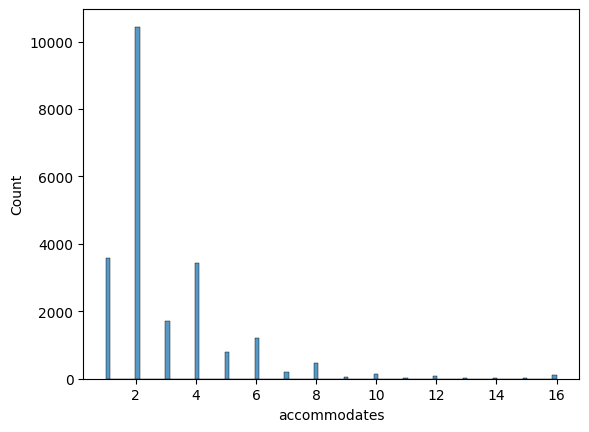

In [181]:
sns.histplot(data=df, x='accommodates')


<Axes: xlabel='room_type', ylabel='count'>

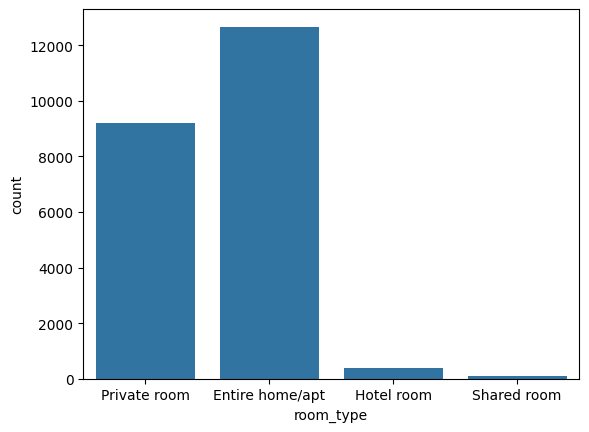

In [36]:
sns.countplot(data=df, x='room_type')

In [182]:
df['property_type'].unique()

array(['Private room in rental unit', 'Private room in condo',
       'Private room in home', 'Entire home', 'Entire rental unit',
       'Private room in guest suite', 'Entire place', 'Entire loft',
       'Entire condo', 'Private room in townhouse', 'Entire townhouse',
       'Private room in bed and breakfast', 'Entire serviced apartment',
       'Private room in loft', 'Entire guesthouse', 'Entire guest suite',
       'Private room in houseboat', 'Room in boutique hotel',
       'Private room', 'Shared room in rental unit', 'Boat',
       'Room in serviced apartment', 'Private room in villa',
       'Private room in religious building', 'Casa particular',
       'Shared room in home', 'Shared room in townhouse',
       'Private room in tiny home', 'Entire bungalow', 'Room in hotel',
       'Private room in guesthouse', 'Houseboat', 'Shared room in condo',
       'Entire cottage', 'Tiny home', 'Shared room in loft',
       'Private room in serviced apartment', 'Room in aparthotel',


In [42]:
df['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Hotel room', 'Shared room'],
      dtype=object)

In [60]:
df['structure_type'].value_counts(normalize=True)

structure_type
rental unit           0.668582
home                  0.132810
condo                 0.046499
townhouse             0.043268
hotel                 0.036535
guest suite           0.017370
loft                  0.015889
serviced apartment    0.009740
boutique hotel        0.009515
place                 0.002738
bed and breakfast     0.002693
aparthotel            0.002558
guesthouse            0.002558
casa particular       0.001975
resort                0.001257
hostel                0.001167
vacation home         0.001077
bungalow              0.000987
villa                 0.000583
tiny home             0.000583
camper/rv             0.000404
houseboat             0.000269
boat                  0.000224
tower                 0.000180
earthen home          0.000135
cottage               0.000135
religious building    0.000090
barn                  0.000045
kezhan                0.000045
ranch                 0.000045
dome                  0.000045
Name: proportion, dtype:

In [ ]:
freq = df['structure_type'].value_counts(normalize=True)
rare = freq[freq<0.01].index
df['structure_type'] = df['structure_type'].replace(rare, 'Other')
# unified_room NaN → "Other_room" 라벨
df['unified_room'] = df['unified_room'].fillna('Other_room')

df = pd.get_dummies(df,
                    columns=['unified_room','structure_type'],
                    prefix=['room','structure'],
                    dtype=int)